## 1. Implement models in Stan 

Call center data set — exponential likelihood with gamma prior. Estimate the number of calls per minute for the 11th hour of the call center data set.
Results to compute:
- Posterior 95% confidence interval over λ (check that it matches results in the
solution notebook below)
- Histogram of posterior λ samples

Resources for you to use:
- Data set: call_center.csv
- Solution for class activity (call_center_solution.ipynb)

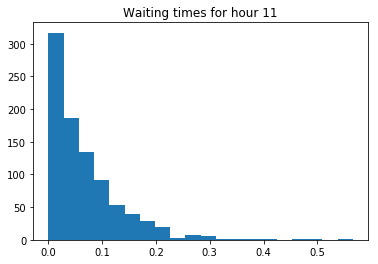

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import pystan

waiting_times_day = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00073825-8976/call-center.csv", header = None)

current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day.iloc[:,0]:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)
    
hour_index = 11
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

In [37]:
stan_code = """

data {  
    real<lower=0> waittimes;  // waiting time before call
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

parameters {
    real<lower=0> l;  
}

model {
    l ~ gamma(alpha, beta);  // prior over p
    waittimes ~ exponential(l);
}

"""

In [38]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_baca347906b172d5959c19aa52604e1f NOW.


In [39]:
stan_results = stan_model.sampling(data=waiting_times_per_hour[11])
print(stan_results.stansummary(pars=['l'], probs=[0.025, 0.5, 0.975]))

AttributeError: 'list' object has no attribute 'items'